In [1]:
import numpy as np
import pickle
import nltk
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [3]:
from nltk.corpus import stopwords
breakers = {'with', 'without', 'comma', 'and', 'or', 'by', 'in', 'due', 'to', 'of', 'causing'}
stop_words= (set(stopwords.words("english")) | {'nan', 'unspecified', 'stated', 'other', 'state'})

In [4]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc1h = OneHotEncoder(handle_unknown='ignore')

In [6]:
df_train = pd.read_csv("data/diabetes/diab_train.csv")
header = df_train.keys()
df_train = np.asarray(df_train)
df_val = np.asarray(pd.read_csv("data/diabetes/diab_validation.csv"))
df_test = np.asarray(pd.read_csv("data/diabetes/diab_test.csv"))

In [7]:
X = np.hstack([df_train[:,:-4], df_train[:,-3:]])
X_val = np.hstack([df_val[:,:-4], df_val[:,-3:]])
X_test = np.hstack([df_test[:,:-4], df_test[:,-3:]])
Y = df_train[:,-4].reshape(-1).astype(int)
Y_val = df_val[:,-4].reshape(-1).astype(int)
Y_test = df_test[:,-4].reshape(-1).astype(int)

In [8]:
X_all = np.vstack([X, X_val, X_test])
Y_all = np.hstack([Y, Y_val, Y_test])
XY = np.vstack([np.hstack([X, Y.reshape(-1, 1)]), np.hstack([X_val, Y_val.reshape(-1, 1)])])

In [9]:
def sanitize(doc, breaks=True):
    return ' '.join([lem.lemmatize(w) for w in tokenizer.tokenize(str(doc).replace(",", " comma").lower())\
                     if w not in stop_words or (breaks and w in breakers)])

In [10]:
def scatterplot(tsne_results, Y_test):
    plt.figure(figsize=(12,12))
    label = Y_test
    colors = ['blue', 'red']
    plt.scatter(x=tsne_results[:,0], y=tsne_results[:,1], c=label, 
                cmap=matplotlib.colors.ListedColormap(colors), s=3)

# Inspect dataset
10'000 samples of 51 features, 6'000 for training, 2'000 validation and 2'000 testing.<br>
We can drop the first column, because all id's are unique.

In [11]:
print("Percentage of not readmitted vs. readmitted:", np.bincount(Y_all) / len(Y_all) * 100)

Percentage of not readmitted vs. readmitted: [60.35 39.65]


In [12]:
def inspect_feature(ix, nan_value=''):
    X_s = XY[:,ix].astype(str)
    print(round(len(X_s[X_s == str(nan_value)])/len(XY)*100, 2), '% of samples are have no value')
    happy = []
    readmitted = []
    labels = []
    for e in set(XY[:,ix]):
        t = XY[XY[:,ix] == e][:,-1]
        if len(t) > 0:
            labels.append(e)
            happy.append(len(t[t == 0]) / len(t) * 100)
            readmitted.append(len(t[t == 1]) / len(t) * 100)
    
    labels = np.asarray(labels)
    sort = np.argsort(labels)
    labels = labels[sort].tolist()
    for i in range(len(labels)):
        labels[i] = str(labels[i])+'\n('+str(len(X_s[X_s == str(labels[i])]))+')'
    
    happy = np.round(np.asarray(happy)[sort], 2)
    readmitted = np.round(np.asarray(readmitted)[sort], 2)
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,6))
    rects1 = ax.bar(x - width/2, happy, width, label='Not readmitted')
    rects2 = ax.bar(x + width/2, readmitted, width, label='Readmitted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(header[ix])
    ax.set_ylabel('%')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    plt.show()

Race

2.15 % of samples are have no value


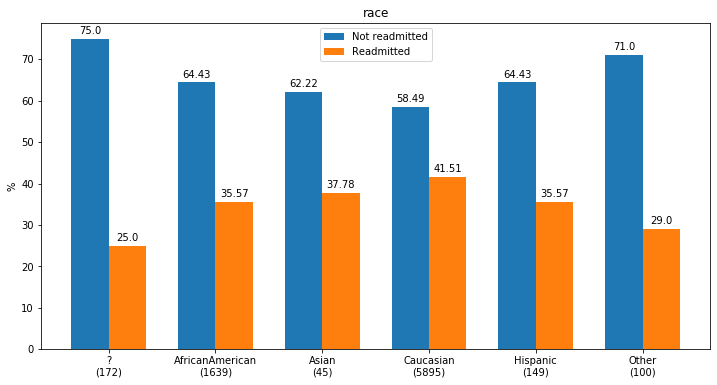

In [13]:
inspect_feature(1, nan_value='?')

In [14]:
print(set(X_all[:,1]))

{'Asian', 'Other', '?', 'AfricanAmerican', 'Hispanic', 'Caucasian'}


Since the distributions for AfricanAmerican, Asian and Hispanic are similar, we group them to have enough samples. Also, we group ? and Other.

In [15]:
race = {'Other': 0, 'Asian':1, 'Caucasian':2, 'Hispanic':1, 'AfricanAmerican':1, '?':0}
X_enc = np.asarray([race[x] for x in X_all[:,1]]).reshape(-1, 1)

Gender

0.0 % of samples are have no value


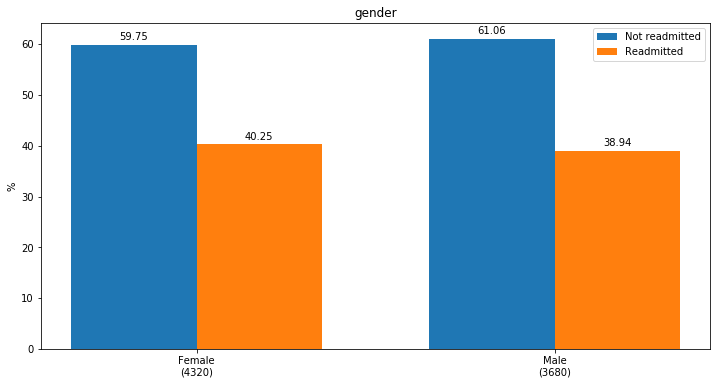

In [16]:
inspect_feature(2)

In [17]:
print(set(X_all[:,2]))

{'Female', 'Male'}


Female and Male have almost the same probabilities. But we don't get rid of this feature, since we could imagine it to be correlated with f.ex. age (we cannot calculate the correlation before the features were encoded, so this is just an assumption)

In [18]:
gender = {'Male': 0, 'Female': 1}
X_enc = np.hstack([X_enc, np.asarray([gender[x] for x in X_all[:, 2]]).reshape(-1, 1)])

Age

0.0 % of samples are have no value


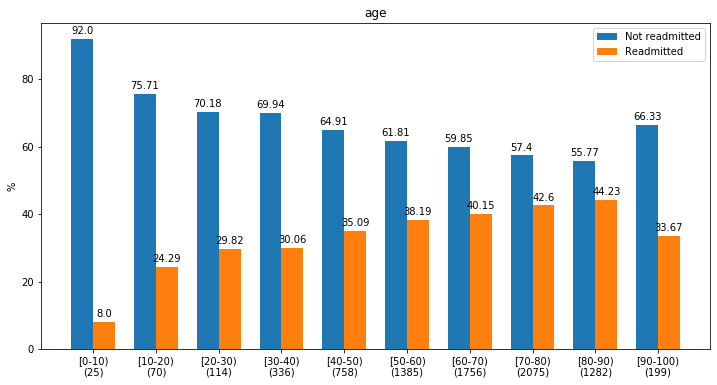

In [19]:
inspect_feature(3)

In [20]:
print(set(X_all[:,3]))

{'[70-80)', '[20-30)', '[40-50)', '[80-90)', '[10-20)', '[60-70)', '[0-10)', '[90-100)', '[50-60)', '[30-40)'}


In [21]:
age = {'[0-10)': 0, '[80-90)': 8, '[60-70)': 6, '[50-60)': 5,\
          '[30-40)': 3, '[20-30)':2, '[90-100)':9, '[40-50)':4, '[70-80)': 7, '[10-20)': 10}
X_enc = np.hstack([X_enc, np.asarray([age[x] for x in X_all[:, 3]]).reshape(-1, 1)])

Weight

95.88 % of samples are have no value


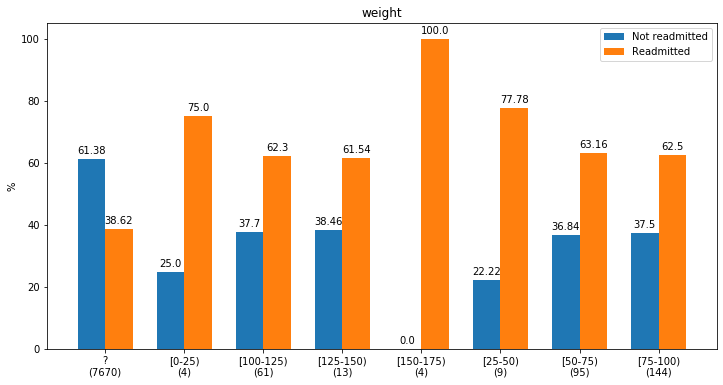

In [22]:
inspect_feature(4, nan_value='?')

In [23]:
print(set(X_all[:,4]))

{'[100-125)', '[50-75)', '[75-100)', '[150-175)', '?', '[125-150)', '[0-25)', '[25-50)'}


Almost 96% of the samples have no value in 'weight'. However, we can observe something very interesting: It seems like the samples that have no value are much less likely to get readmitted than the ones with a value. We therefore create just two groups: one for '?' and one for the rest.

In [24]:
weight = {'[25-50)': 1, '[150-175)': 1, '[75-100)': 1, '[0-25)': 1,
          '[125-150)': 1, '[50-75)': 1, '[100-125)':1, '?': 0}
X_enc = np.hstack([X_enc, np.asarray([weight[str(x)] for x in X_all[:, 4]]).reshape(-1, 1)])

Admission Type ID

7.07 % of samples are have no value


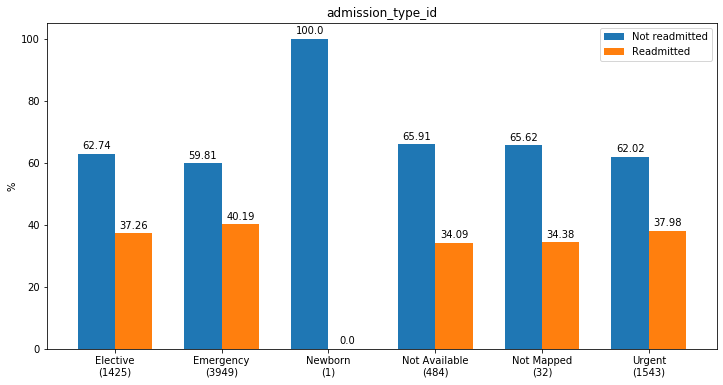

In [25]:
inspect_feature(5, nan_value='nan')

In [26]:
print(set(X_all[:,5]))

{nan, 'Emergency', 'Not Available', 'Not Mapped', 'Newborn', 'Elective', 'Urgent'}


Here we have 3 groups that basically mean the same thing: nan, not mapped and not available - we put them in the same group. The others were ordered by severity: 1 for elective, 2 for urgent and 3 for emergency.

In [27]:
admission_type = {'nan': 0, 'Newborn': 0, 'Emergency':3,\
                  'Not Mapped': 0, 'Not Available': 0, 'Urgent': 2, 'Elective': 1}
X_enc = np.hstack([X_enc, np.asarray([admission_type[str(x)] for x in X_all[:, 5]]).reshape(-1, 1)])

### Discharge Disposition ID

4.65 % of samples are have no value


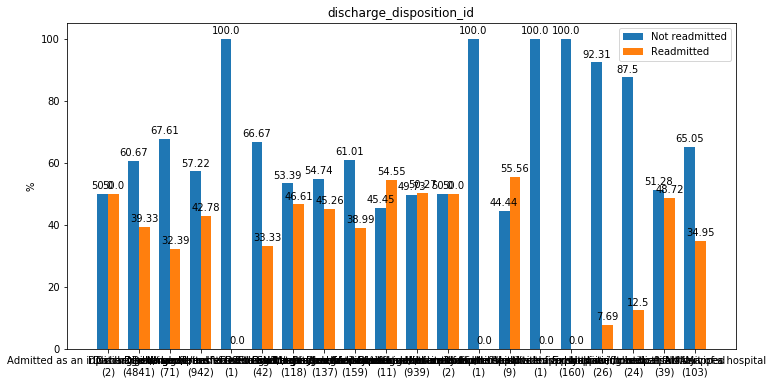

In [28]:
inspect_feature(6, nan_value='nan')

In [29]:
print(len(set(X_all[:,6])), 'Items')
print(sorted(list(set(X_all[:,6].astype(str)))))

22 Items
['Admitted as an inpatient to this hospital', 'Discharged to home', 'Discharged/transferred to ICF', 'Discharged/transferred to SNF', 'Discharged/transferred to a federal health care facility.', 'Discharged/transferred to a long term care hospital.', 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare', 'Discharged/transferred to another  type of inpatient care institution', 'Discharged/transferred to another rehab fac including rehab units of a hospital.', 'Discharged/transferred to another short term hospital', 'Discharged/transferred to home under care of Home IV provider', 'Discharged/transferred to home with home health service', 'Discharged/transferred within this institution to Medicare approved swing bed', 'Discharged/transferred/referred another institution for outpatient services', 'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital', 'Discharged/transferred/r

Here we want the similar dispositions to have a similar encoding. We therefore run LDA with 3 topics.

In [30]:
discharge_disposition = [sanitize(str(d), breaks=False) for d in set(X_all[:,6])]
cvec_dis = CountVectorizer(ngram_range=(1,1))
occmat_dis = cvec_dis.fit_transform(discharge_disposition).toarray()
lda_dis = LatentDirichletAllocation(n_components=3)
lda_dis = lda_dis.fit(occmat_dis)

In [31]:
X_dis = np.asarray([lda_dis.transform(cvec_dis.transform([sanitize(str(d), breaks=False)]).toarray()) 
                                      for d in X_all[:,6]]).reshape(-1, 3)
X_enc = np.hstack([X_enc, X_dis])

In [32]:
X_dis.shape

(10000, 3)

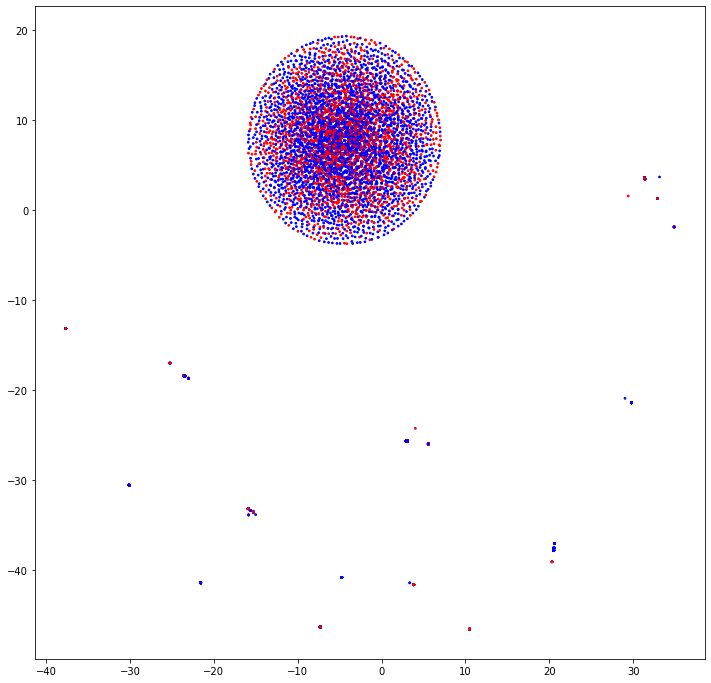

In [33]:
scatterplot(TSNE().fit_transform(X_dis), Y_all)

There is a cluster of points, probably all the samples starting with 'Discharged/transferred'. The other samples are scattered around. It is hard to classify samples just by looking at this plot though.

### Admission Source ID

9.26 % of samples are have no value


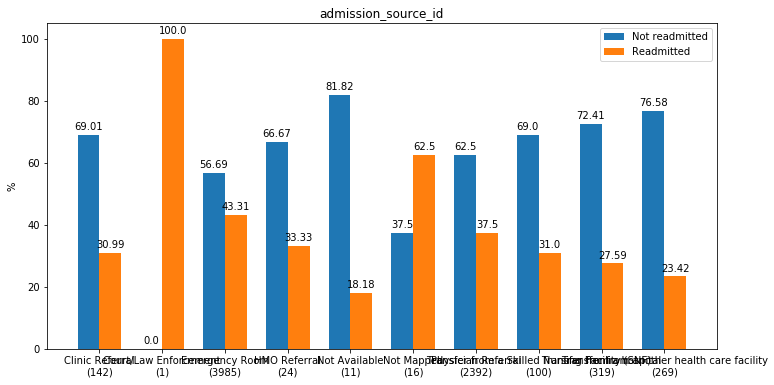

In [34]:
inspect_feature(7, nan_value='nan')

In [35]:
print(sorted(list(set(X_all[:,7].astype(str)))))

['Clinic Referral', 'Court/Law Enforcement', 'Emergency Room', 'HMO Referral', 'Not Available', 'Not Mapped', 'Physician Referral', 'Transfer from a Skilled Nursing Facility (SNF)', 'Transfer from a hospital', 'Transfer from another health care facility', 'nan']


Here we create 6 groups and since there is not a measure of similarity between them, we one-hot encode them. 'Not Available', 'Not Mapped' and 'nan' go into the same group, as well as 'Court/Law Enforcement', since it only appears once in the dataset.

In [36]:
admission_src_id = {'Clinic Referral':[0,1,0,0,0,0], \
                    'Court/Law Enforcement':[1,0,0,0,0,0], \
                    'Emergency Room':[0,0,1,0,0,0], \
                    'HMO Referral':[0,0,0,1,0,0], \
                    'Not Available':[1,0,0,0,0,0], \
                    'Not Mapped':[1,0,0,0,0,0], \
                    'nan':[1,0,0,0,0,0], \
                    'Physician Referral':[0,0,0,0,1,0], \
                    'Transfer from a Skilled Nursing Facility (SNF)':[0,0,0,0,0,1], \
                    'Transfer from a hospital':[0,0,0,0,0,1], \
                    'Transfer from another health care facility':[0,0,0,0,0,1]}
X_enc = np.hstack([X_enc, np.asarray([admission_src_id[str(x)] for x in X_all[:, 7]]).reshape(-1, 6)])

### Time in hospital

0.0 % of samples are have no value


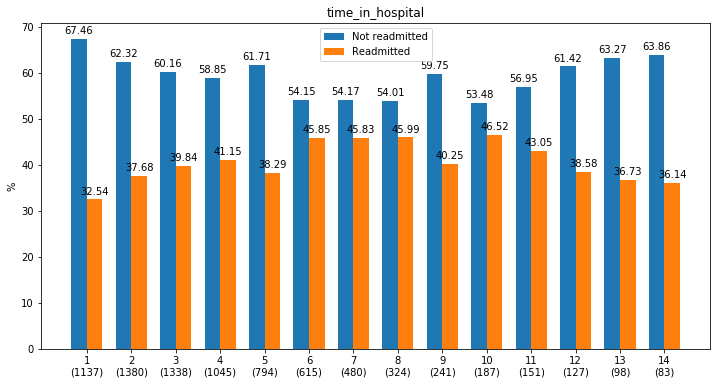

In [37]:
inspect_feature(8)

In [38]:
print(set(X_all[:,8]))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


This feature doesn't need to be encoded.

In [39]:
X_enc = np.hstack([X_enc, X_all[:,8].reshape(-1, 1)])

### Payer Code

53.44 % of samples are have no value


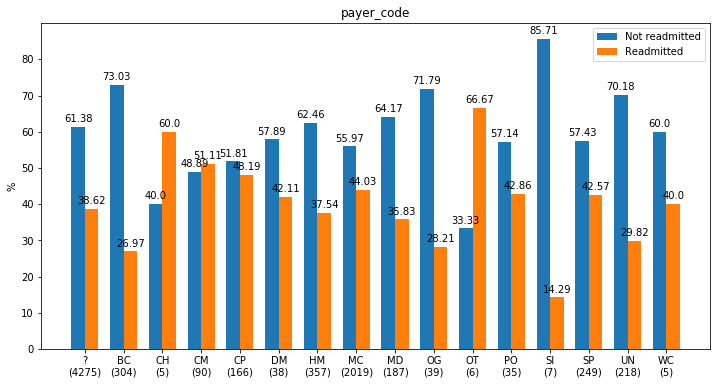

In [40]:
inspect_feature(9, nan_value='?')

In [41]:
print(set(X_all[:,9]))

{'OG', 'SI', 'UN', 'BC', 'CM', 'MD', 'SP', 'PO', 'OT', 'CH', 'WC', '?', 'CP', 'DM', 'HM', 'MC'}


This feature has to be one-hot encoded too. Since this introduces a lot of dimensions, we only want to keep the classes containing enough samples to be significative. 

In [42]:
enc1h = OneHotEncoder(handle_unknown='ignore')
enc1h.fit(np.asarray(['BC', 'CM', 'SP', 'UN', 'HM', 'MC', 'CP', 'MD']).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [43]:
X_enc = np.hstack([X_enc, enc1h.transform(X_all[:,9].astype(str).reshape(-1, 1)).toarray()])

### Medical speciality

40.91 % of samples are have no value


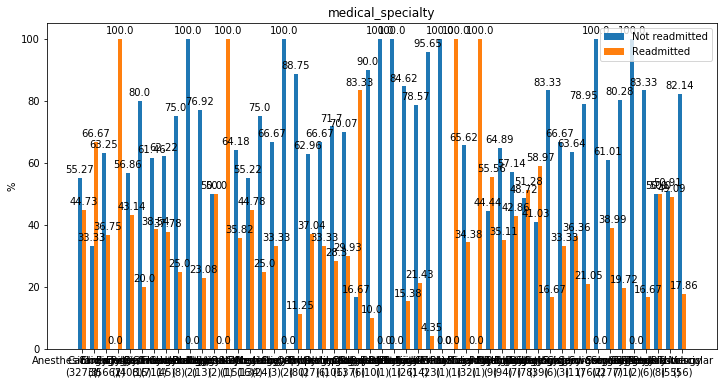

In [44]:
inspect_feature(10, nan_value='?')

In [45]:
print(len(set(X_all[:,10])), 'different classes')
print(sorted([s for s in set(X_all[:,10])]))

53 different classes
['?', 'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric', 'Emergency/Trauma', 'Endocrinology', 'Family/GeneralPractice', 'Gastroenterology', 'Gynecology', 'Hematology', 'Hematology/Oncology', 'Hospitalist', 'InfectiousDiseases', 'InternalMedicine', 'Nephrology', 'Neurology', 'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics', 'ObstetricsandGynecology', 'Oncology', 'Ophthalmology', 'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath', 'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics', 'Pediatrics-CriticalCare', 'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology', 'Pediatrics-Pulmonology', 'PhysicalMedicineandRehabilitation', 'PhysicianNotFound', 'Podiatry', 'Psychiatry', 'Psychology', 'Pulmonology', 'Radiologist', 'Radiology', 'Surgeon', 'Surgery-Cardiovascular', 'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Neuro', 'Surgery-Pediatric', 'Surgery-Plasti

This feature has 53 different classes and 41% of the samples don't have a value. We will drop this feature.

### Num Lab Procedures

0.0 % of samples are have no value


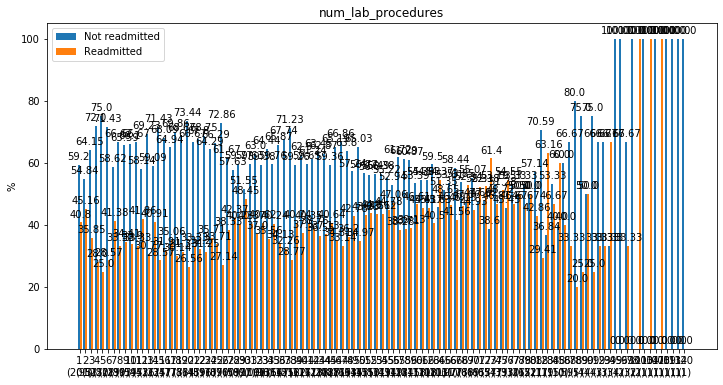

In [46]:
inspect_feature(11)

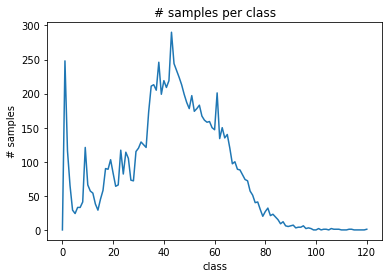

In [47]:
plt.title('# samples per class')
plt.xlabel('class')
plt.ylabel('# samples')
plt.plot(np.bincount(X_all[:,11].astype(int)))

In [48]:
print(set(X_all[:,11]))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 103, 104, 106, 107, 108, 109, 113, 114, 120}


In [49]:
X_nlabproc = X_all[:,11].astype(int).copy()
X_nlabproc[X_nlabproc >= 80] = 80

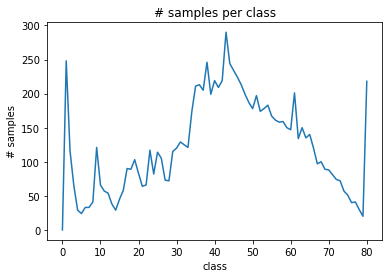

In [50]:
plt.title('# samples per class')
plt.xlabel('class')
plt.ylabel('# samples')
plt.plot(np.bincount(X_nlabproc))

In [51]:
X_enc = np.hstack([X_enc, X_nlabproc.reshape(-1, 1)])

### Number of procedures

0.0 % of samples are have no value


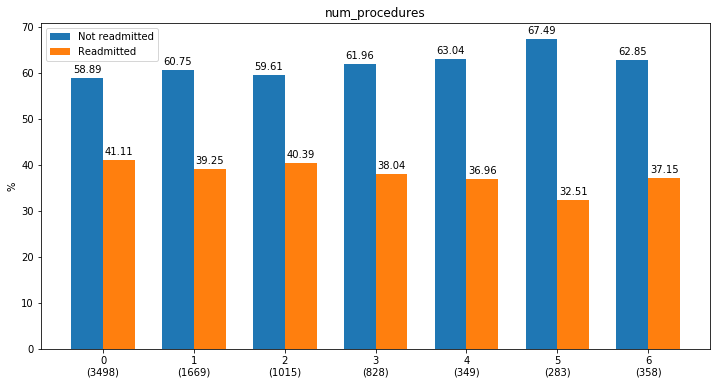

In [52]:
inspect_feature(12)

In [53]:
print(set(X_all[:,12]))

{0, 1, 2, 3, 4, 5, 6}


In [54]:
X_enc = np.hstack([X_enc, X_all[:,12].reshape(-1, 1)])

### Number of medications

0.0 % of samples are have no value


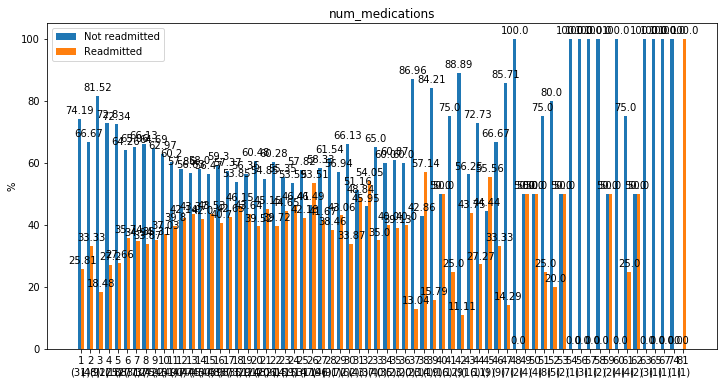

In [55]:
inspect_feature(13)

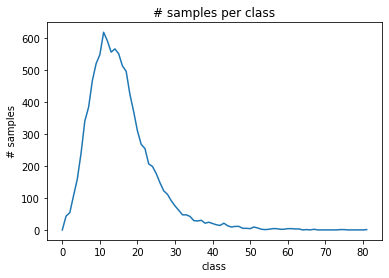

In [56]:
plt.title('# samples per class')
plt.xlabel('class')
plt.ylabel('# samples')
plt.plot(np.bincount(X_all[:,13].astype(int)))

In [57]:
print(set(X_all[:,13]))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 74, 75, 81}


In [58]:
X_nmed = X_all[:,13].astype(int).copy()
X_nmed[np.logical_and(X_nmed >= 30, X_nmed < 40)] = 30
X_nmed[X_nmed >= 40] = 40

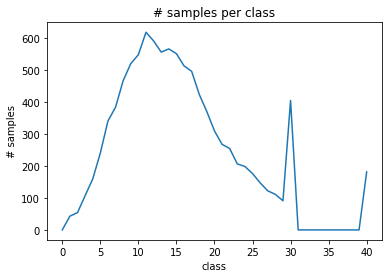

In [59]:
plt.title('# samples per class')
plt.xlabel('class')
plt.ylabel('# samples')
plt.plot(np.bincount(X_nmed))

In [60]:
X_enc = np.hstack([X_enc, X_nmed.reshape(-1, 1)])

### Number outpatient

0.0 % of samples are have no value


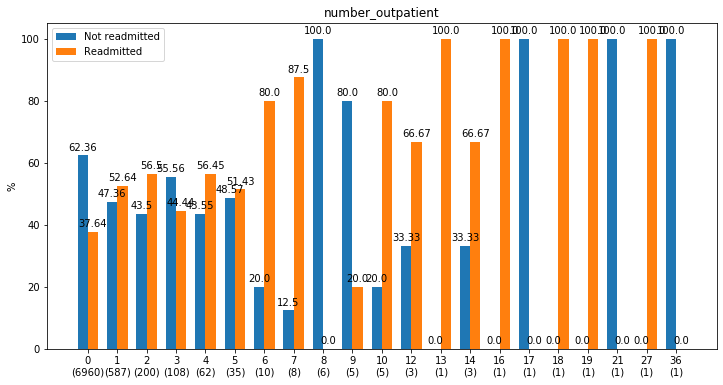

In [61]:
inspect_feature(14)

In [62]:
print(set(X_all[:,14]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 27, 36}


In [63]:
X_outp = X_all[:,14].astype(int).copy()
X_outp[X_outp >= 6] = 6

In [64]:
X_enc = np.hstack([X_enc, X_outp.reshape(-1, 1)])

### Number of emergencies

0.0 % of samples are have no value


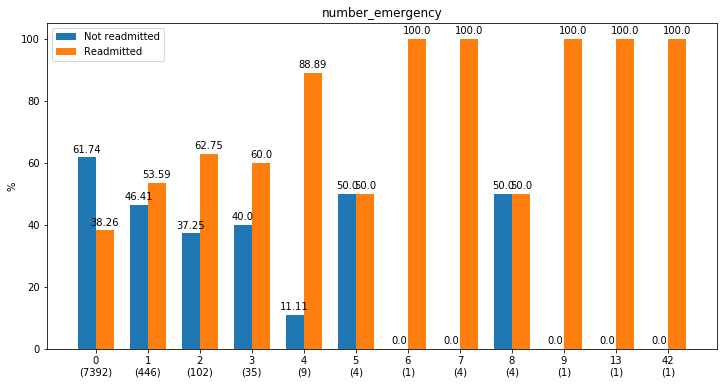

In [65]:
inspect_feature(15)

In [66]:
print(set(X_all[:,15]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 42, 13}


In [67]:
X_em = X_all[:,15].astype(int).copy()
X_em[X_em >= 4] = 4

In [68]:
X_enc = np.hstack([X_enc, X_em.reshape(-1, 1)])

### Number of inpatient

0.0 % of samples are have no value


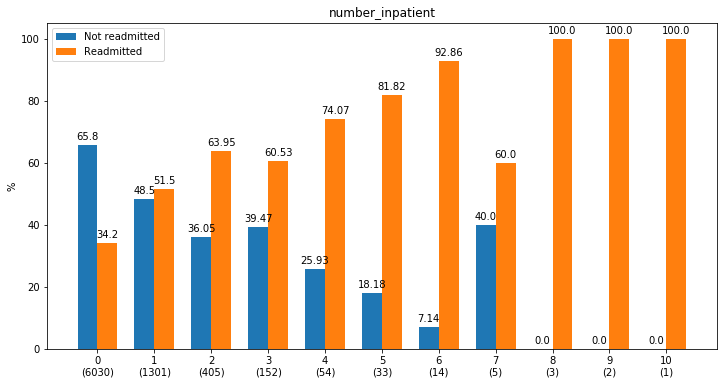

In [69]:
inspect_feature(16)

In [70]:
print(set(X_all[:,16]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [71]:
X_inp = X_all[:,16].astype(int).copy()
X_inp[X_em >= 6] = 6

In [72]:
X_enc = np.hstack([X_enc, X_inp.reshape(-1, 1)])

### Number of diagnoses

0.0 % of samples are have no value


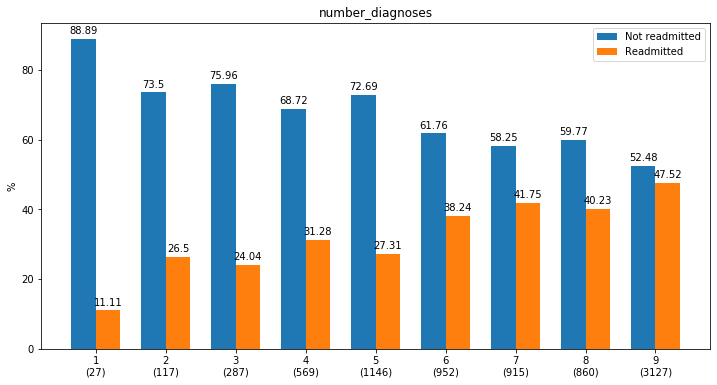

In [73]:
inspect_feature(20)

In [74]:
print(set(X_all[:,20]))

{1, 2, 3, 4, 5, 6, 7, 8, 9}


In [75]:
X_enc = np.hstack([X_enc, X_all[:,20].astype(int).reshape(-1, 1)])

### Max glu serum

93.42 % of samples are have no value


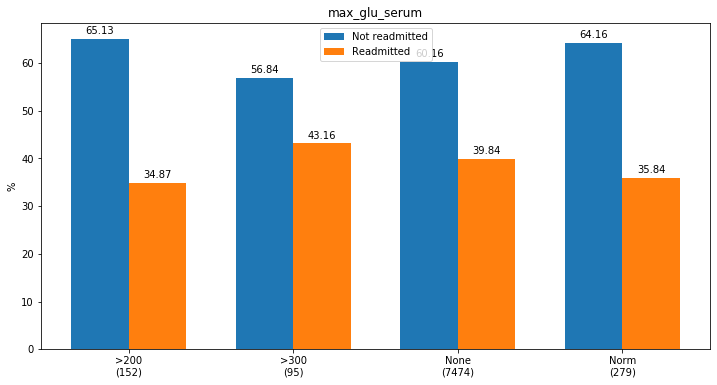

In [76]:
inspect_feature(21, 'None')

In [77]:
print(set(X_all[:,21]))

{'>300', 'Norm', '>200', 'None'}


In [78]:
max_glu_serum = {'Norm':0, '>300':2, 'None':1, '>200':0}
X_enc = np.hstack([X_enc, np.asarray([max_glu_serum[str(x)] for x in X_all[:, 21]]).reshape(-1, 1)])

###  A1C result

84.06 % of samples are have no value


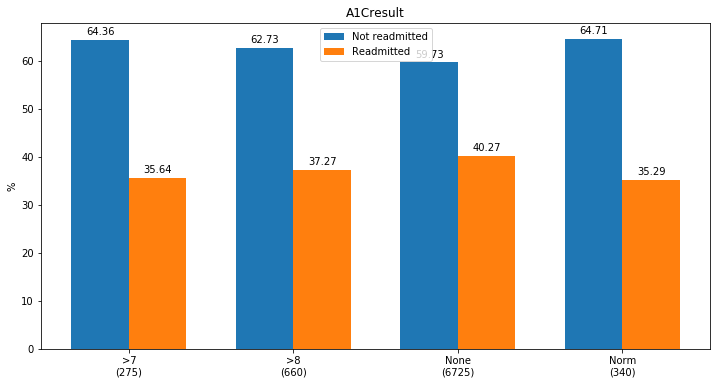

In [79]:
inspect_feature(22, 'None')

In [80]:
print(set(X_all[:,22]))

{'>7', 'Norm', '>8', 'None'}


In [81]:
a1c_res = {'>7': 1, 'Norm': 1, '>8': 1, 'None': 0}
X_enc = np.hstack([X_enc, np.asarray([a1c_res[str(x)] for x in X_all[:, 22]]).reshape(-1, 1)])

### Metformin

0.0 % of samples are have no value


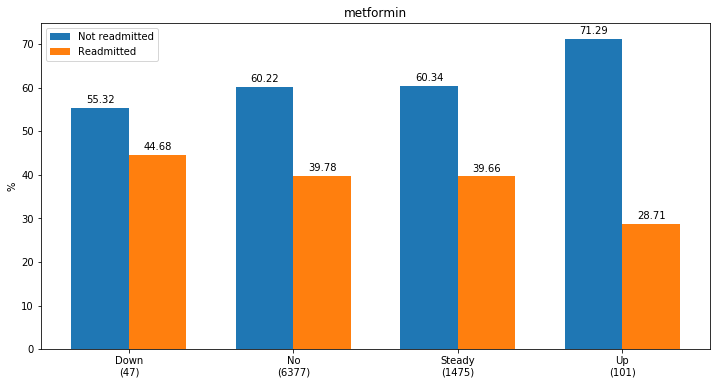

In [82]:
inspect_feature(23)

In [83]:
drug_change = {'Down': 1, 'No': 0, 'Steady': 2, 'Up': 3}
X_enc = np.hstack([X_enc, np.asarray([drug_change[str(x)] for x in X_all[:, 23]]).reshape(-1, 1)])

### Repaglinide

0.0 % of samples are have no value


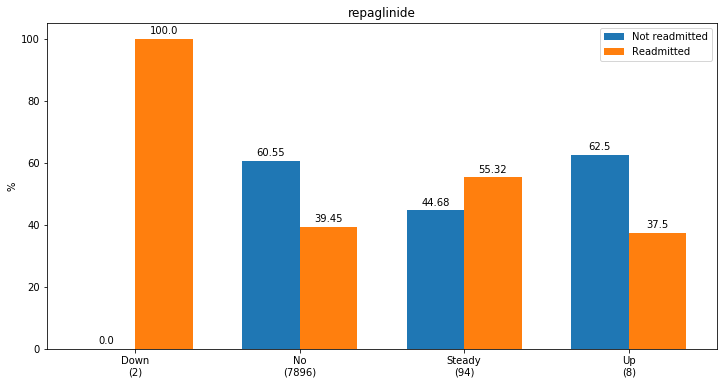

In [84]:
inspect_feature(24)

We will only take 2 classes here, 'No' and 'Steady'.

In [85]:
repaglinide = {'Down': 1, 'No': 0, 'Steady': 1, 'Up': 1}
X_enc = np.hstack([X_enc, np.asarray([repaglinide[str(x)] for x in X_all[:, 24]]).reshape(-1, 1)])

### Nateglinide

0.0 % of samples are have no value


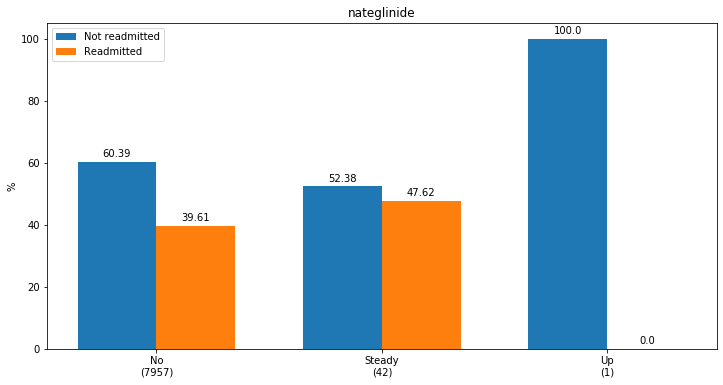

In [86]:
inspect_feature(25)

In [87]:
nateglinide = {'Down': 1, 'No': 0, 'Steady': 1, 'Up': 1}
X_enc = np.hstack([X_enc, np.asarray([nateglinide[str(x)] for x in X_all[:, 25]]).reshape(-1, 1)])

### Chlorpropamide
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


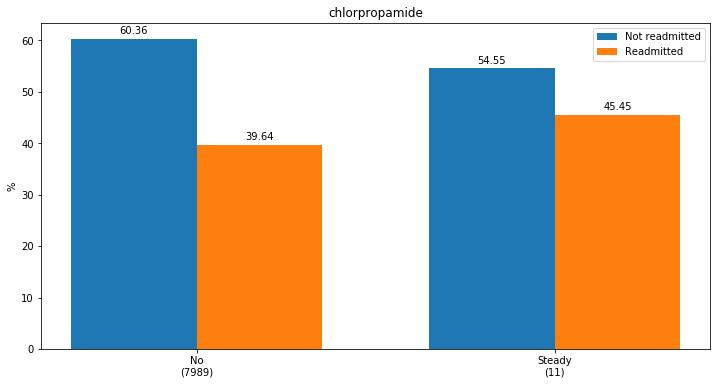

In [88]:
inspect_feature(26)

### Glimepiride

0.0 % of samples are have no value


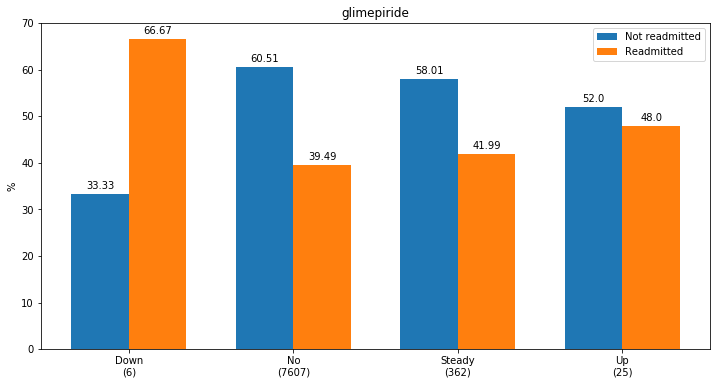

In [89]:
inspect_feature(27)

In [90]:
glimepiride = {'Down': 1, 'No': 0, 'Steady': 1, 'Up': 1}
X_enc = np.hstack([X_enc, np.asarray([glimepiride[str(x)] for x in X_all[:, 27]]).reshape(-1, 1)])

### Acetohexamide
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


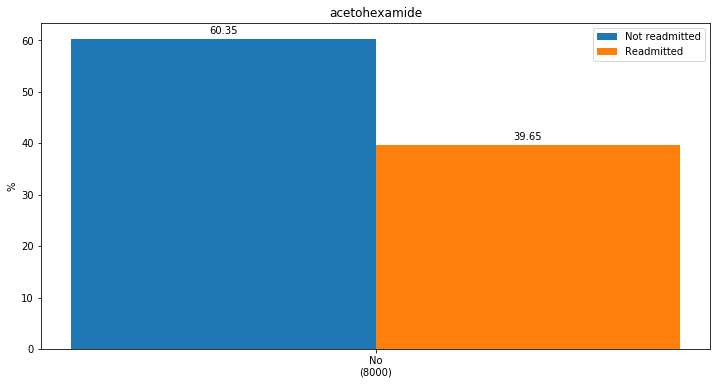

In [91]:
inspect_feature(28)

### Glipizide

0.0 % of samples are have no value


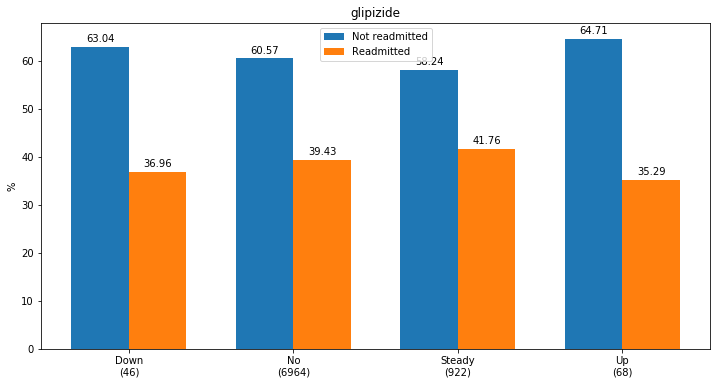

In [92]:
inspect_feature(29)

In [93]:
glipizide = {'Down': 1, 'No': 0, 'Steady': 2, 'Up': 3}
X_enc = np.hstack([X_enc, np.asarray([glipizide[str(x)] for x in X_all[:, 29]]).reshape(-1, 1)])

### Glyburide

0.0 % of samples are have no value


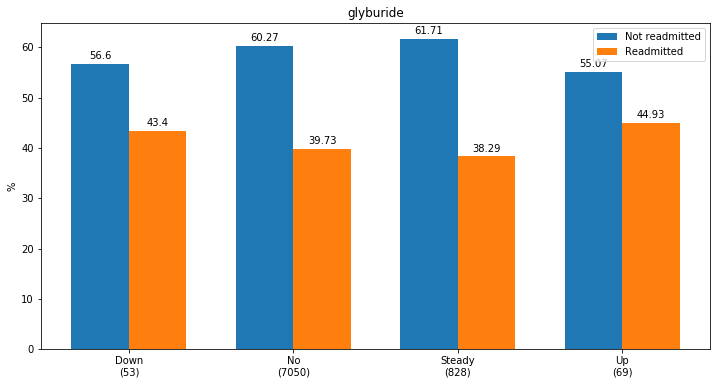

In [94]:
inspect_feature(30)

In [95]:
glyburide = {'Down': 1, 'No': 0, 'Steady': 2, 'Up': 3}
X_enc = np.hstack([X_enc, np.asarray([glyburide[str(x)] for x in X_all[:, 30]]).reshape(-1, 1)])

### Tolbutamide
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


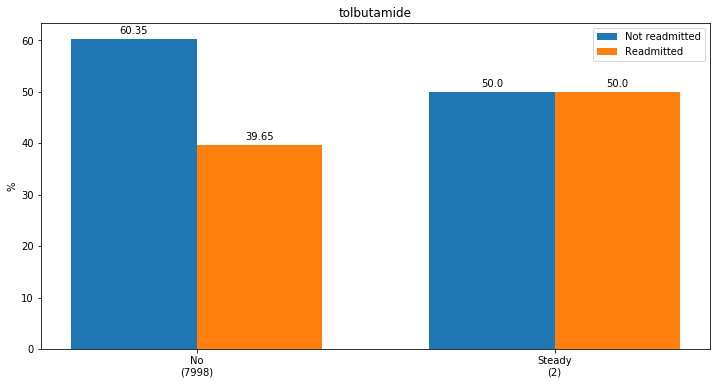

In [96]:
inspect_feature(31)

### Pioglitazone

0.0 % of samples are have no value


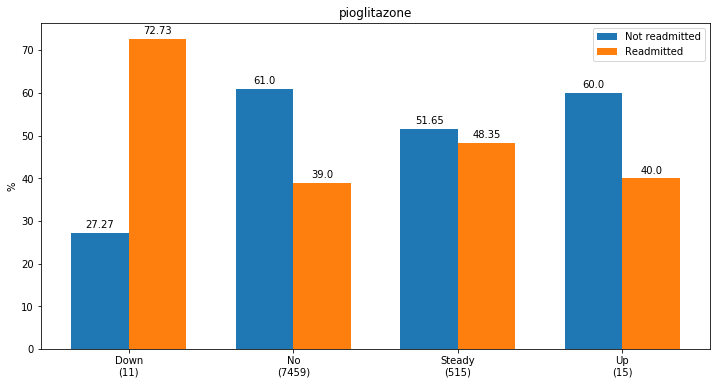

In [97]:
inspect_feature(32)

In [98]:
pioglitazone = {'Down': 1, 'No': 0, 'Steady': 1, 'Up': 1}
X_enc = np.hstack([X_enc, np.asarray([pioglitazone[str(x)] for x in X_all[:, 32]]).reshape(-1, 1)])

### Rosiglitazone

0.0 % of samples are have no value


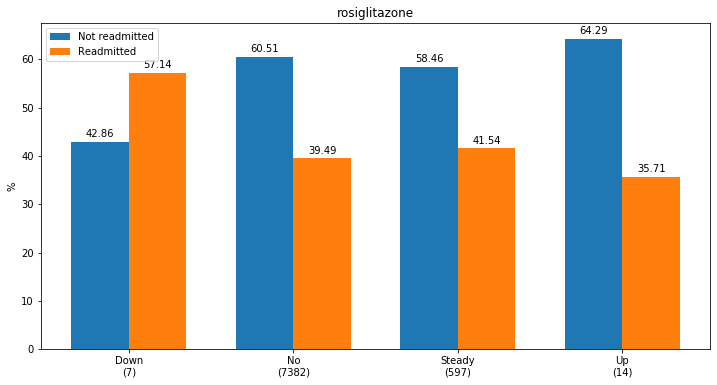

In [99]:
inspect_feature(33)

In [100]:
rosiglitazone = {'Down': 1, 'No': 0, 'Steady': 1, 'Up': 1}
X_enc = np.hstack([X_enc, np.asarray([rosiglitazone[str(x)] for x in X_all[:, 33]]).reshape(-1, 1)])

### Acarbose
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


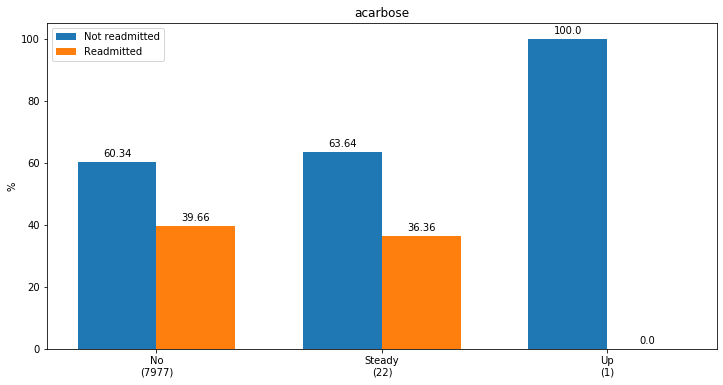

In [101]:
inspect_feature(34)

### Miglitol
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


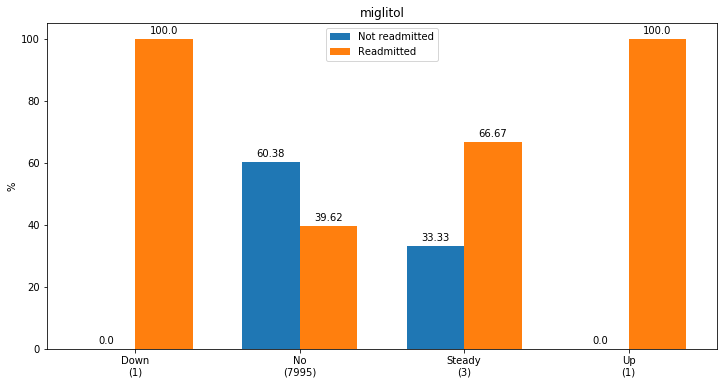

In [102]:
inspect_feature(35)

### Troglitazone
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


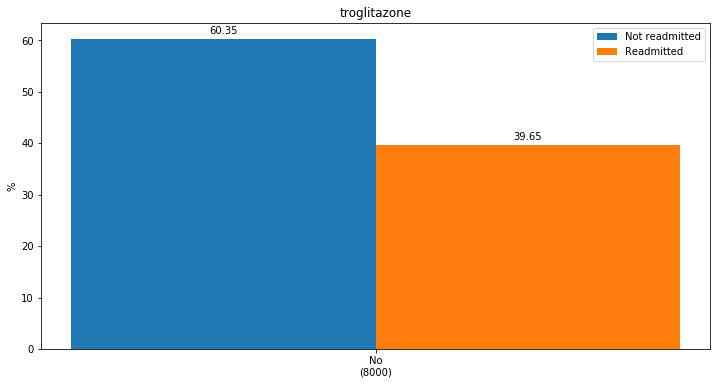

In [103]:
inspect_feature(36)

### Tolazamide
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


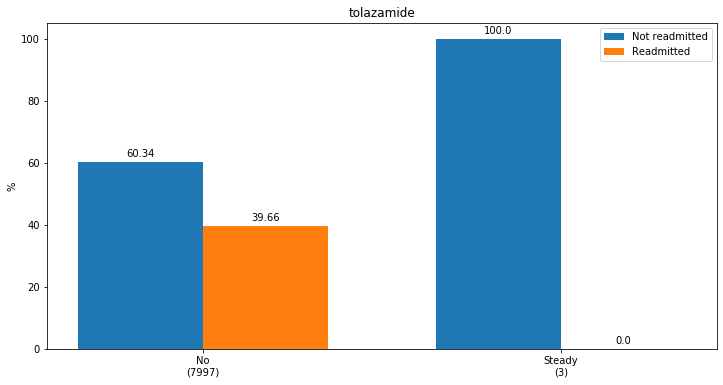

In [104]:
inspect_feature(37)

### Examide
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


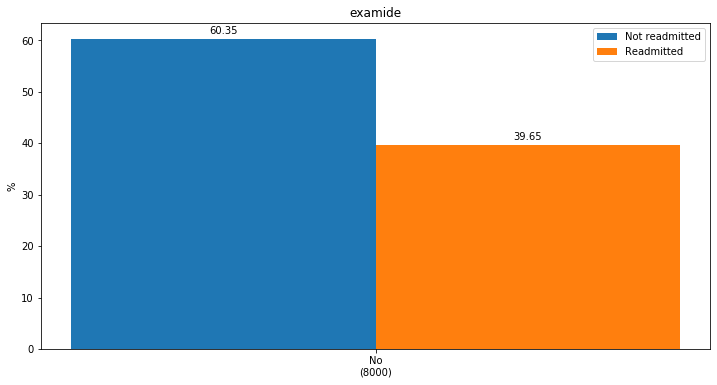

In [105]:
inspect_feature(38)

### Citoglipton
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


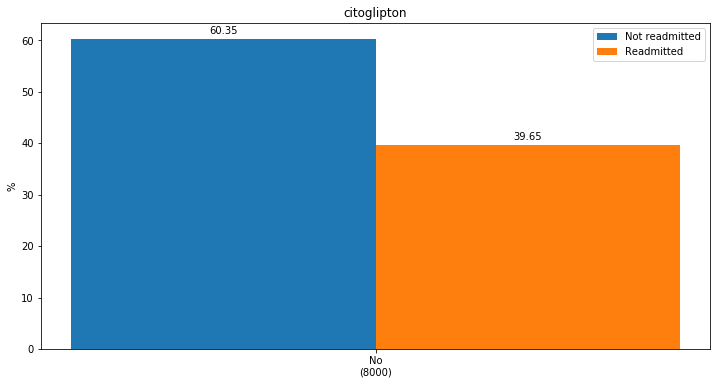

In [106]:
inspect_feature(39)

### Insulin

0.0 % of samples are have no value


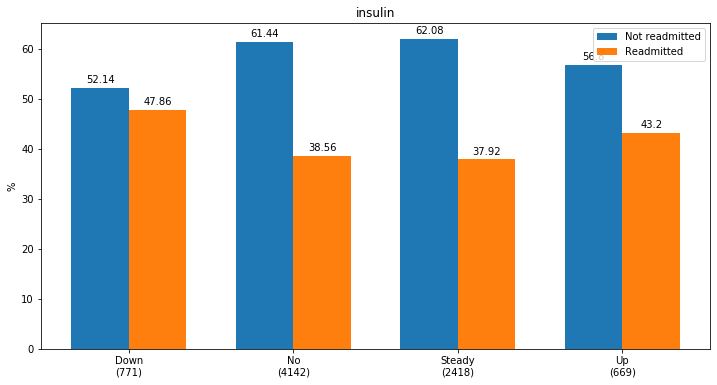

In [107]:
inspect_feature(40)

In [108]:
insulin = {'Down': 1, 'No': 0, 'Steady': 2, 'Up': 3}
X_enc = np.hstack([X_enc, np.asarray([insulin[str(x)] for x in X_all[:, 40]]).reshape(-1, 1)])

### Glyburide Metformin
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


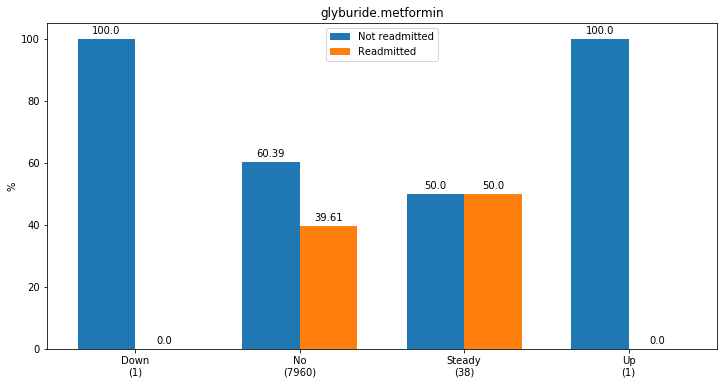

In [109]:
inspect_feature(41)

### Glipizide Metformin
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


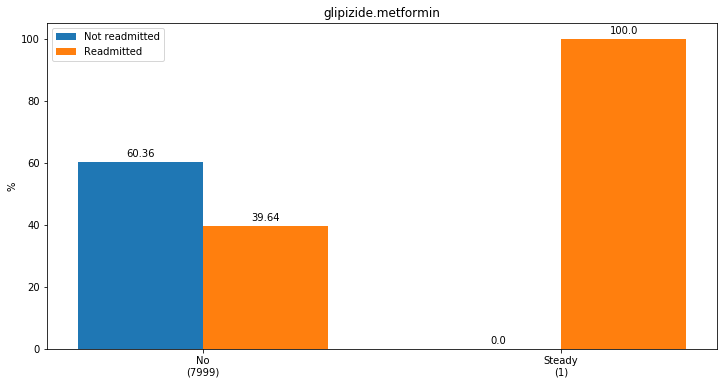

In [110]:
inspect_feature(42)

### Glimepiride Pioglitazone
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


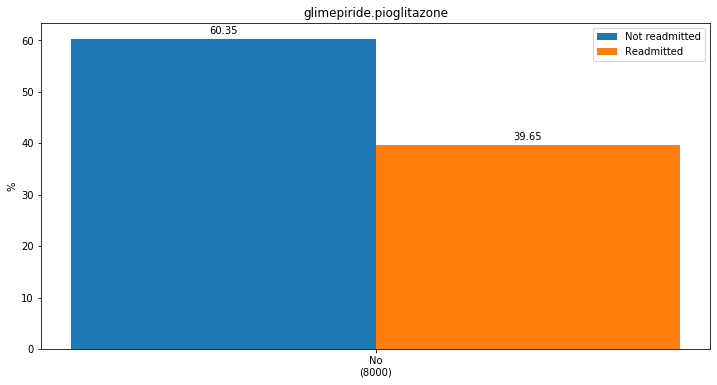

In [111]:
inspect_feature(43)

### Metformin Rosiglitazone
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


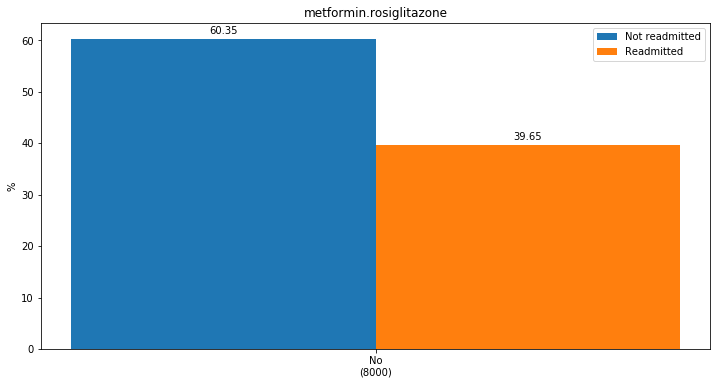

In [112]:
inspect_feature(44)

### Metformin Pioglitazone
This feature can be removed, since almost all of the samples have value 'No'

0.0 % of samples are have no value


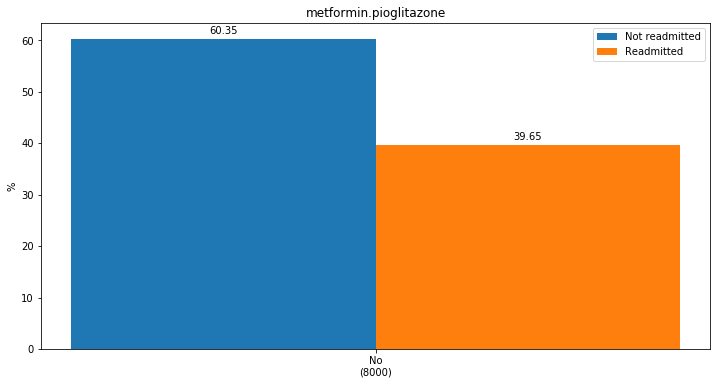

In [113]:
inspect_feature(45)

### Change

0.0 % of samples are have no value


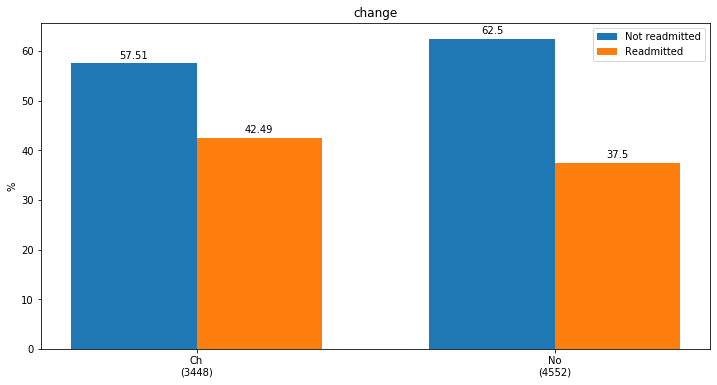

In [114]:
inspect_feature(46)

In [115]:
change = {'No': 0, 'Ch': 1}
X_enc = np.hstack([X_enc, np.asarray([change[str(x)] for x in X_all[:, 46]]).reshape(-1, 1)])

### Diabetes Med

0.0 % of samples are have no value


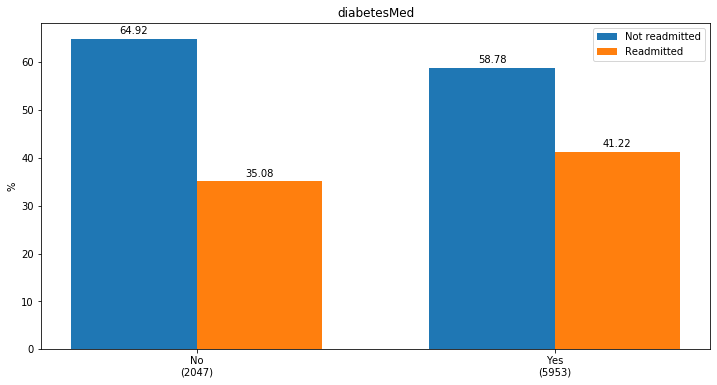

In [116]:
inspect_feature(47)

In [117]:
diabetes_med = {'No': 0, 'Yes': 1}
X_enc = np.hstack([X_enc, np.asarray([diabetes_med[str(x)] for x in X_all[:, 47]]).reshape(-1, 1)])

In [118]:
X_enc.shape

(10000, 43)

### Diagnoses Description

In [119]:
diagnoses = sorted([sanitize(s) for s in set(X_all[:,48])|set(X_all[:,49])|set(X_all[:,50])])

In [120]:
cvecdiag = CountVectorizer(ngram_range=(1,3))
occmatdiag = cvecdiag.fit_transform(diagnoses).toarray()

In [121]:
ldadiag = LatentDirichletAllocation(n_components=10)
ldadiag = ldadiag.fit(occmatdiag)

In [122]:
pcadiag = PCA(n_components=10)
pcadiag = pcadiag.fit(occmatdiag)

In [123]:
X_diagnoses1_pca = np.asarray([pcadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,48]])\
    .reshape(10000, -1)
X_diagnoses1_lda = np.asarray([ldadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,48]])\
    .reshape(10000, -1)

In [124]:
X_diagnoses2_pca = np.asarray([pcadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,49]])\
    .reshape(10000, -1)
X_diagnoses2_lda = np.asarray([ldadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,49]])\
    .reshape(10000, -1)

In [125]:
X_diagnoses3_pca = np.asarray([pcadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,50]])\
    .reshape(10000, -1)
X_diagnoses3_lda = np.asarray([ldadiag.transform(cvecdiag.transform([sanitize(d)]).toarray()) for d in X_all[:,50]])\
    .reshape(10000, -1)

In [126]:
X_diagnoses_pca_mean = np.asarray([np.mean(np.vstack([X_diagnoses1_pca[i], 
                                                      X_diagnoses2_pca[i], 
                                                      X_diagnoses3_pca[i]]), axis=0)
                                   for i in range(10000)])
print(X_diagnoses_pca_mean.shape)

(10000, 10)


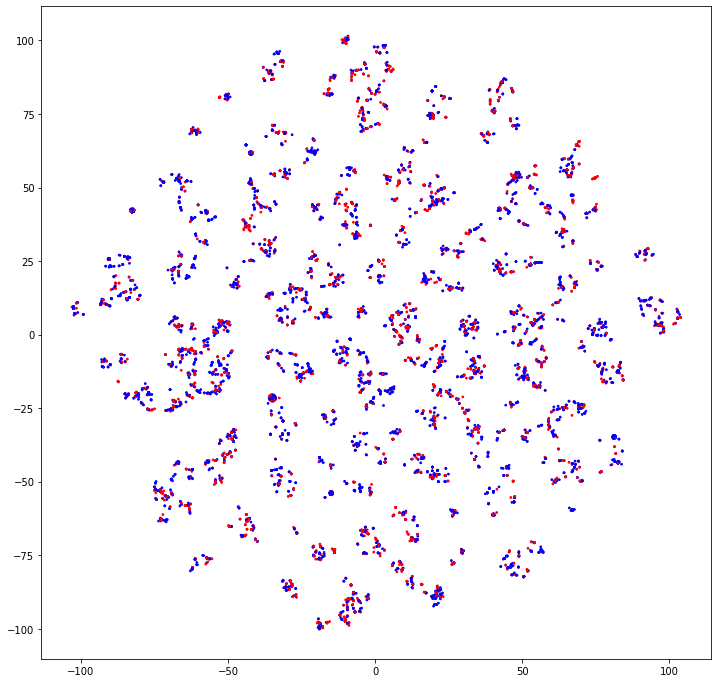

In [127]:
scatterplot(TSNE().fit_transform(X_diagnoses_pca_mean), Y_all)

In [131]:
np.savetxt("data/diabetes/X_pca_mean.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_pca_mean])), 
           delimiter=",")

In [132]:
X_diagnoses_lda_mean = np.asarray([np.mean(np.vstack([X_diagnoses1_lda[i], 
                                                      X_diagnoses2_lda[i], 
                                                      X_diagnoses3_lda[i]]), axis=0) 
                                   for i in range(10000)])
print(X_diagnoses_lda_mean.shape)

(10000, 10)


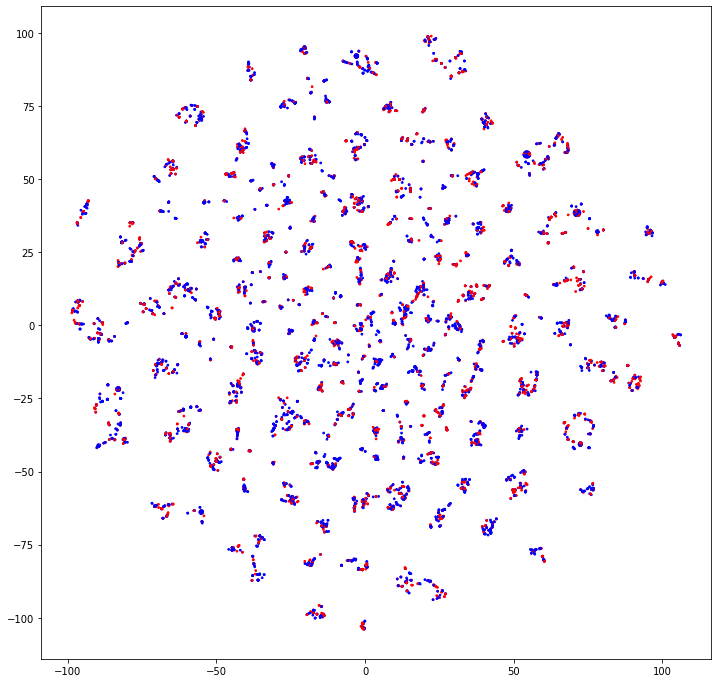

In [133]:
scatterplot(TSNE().fit_transform(X_diagnoses_lda_mean), Y_all)

In [134]:
np.savetxt("data/diabetes/X_lda_mean.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_lda_mean])), 
           delimiter=",")

In [135]:
X_diagnoses_pca_max = np.asarray([np.max(np.vstack([X_diagnoses1_pca[i], 
                                                      X_diagnoses2_pca[i], 
                                                      X_diagnoses3_pca[i]]), axis=0) 
                                   for i in range(10000)])
print(X_diagnoses_pca_max.shape)

(10000, 10)


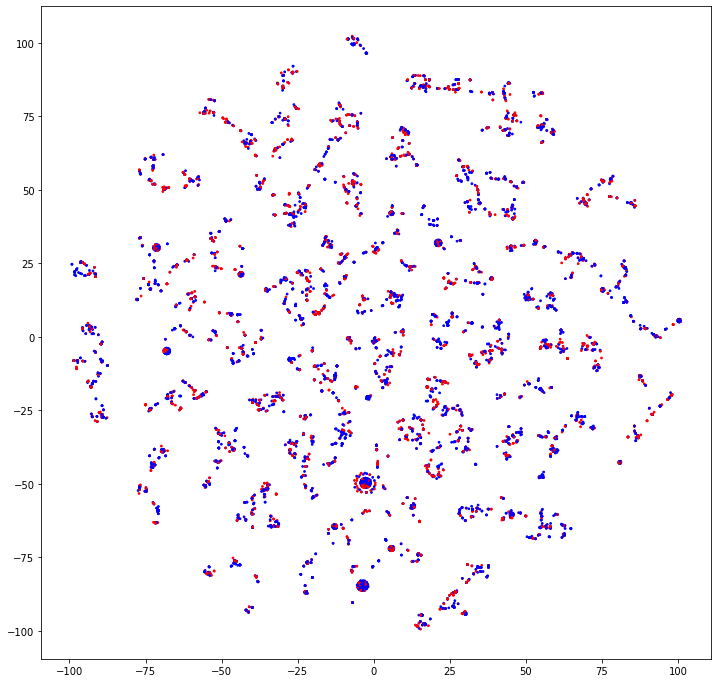

In [136]:
scatterplot(TSNE().fit_transform(X_diagnoses_pca_max), Y_all)

In [137]:
np.savetxt("data/diabetes/X_pca_max.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_pca_max])), 
           delimiter=",")

In [138]:
X_diagnoses_lda_max = np.asarray([np.max(np.vstack([X_diagnoses1_lda[i], 
                                                      X_diagnoses2_lda[i], 
                                                      X_diagnoses3_lda[i]]), axis=0) 
                                   for i in range(10000)])
print(X_diagnoses_lda_max.shape)

(10000, 10)


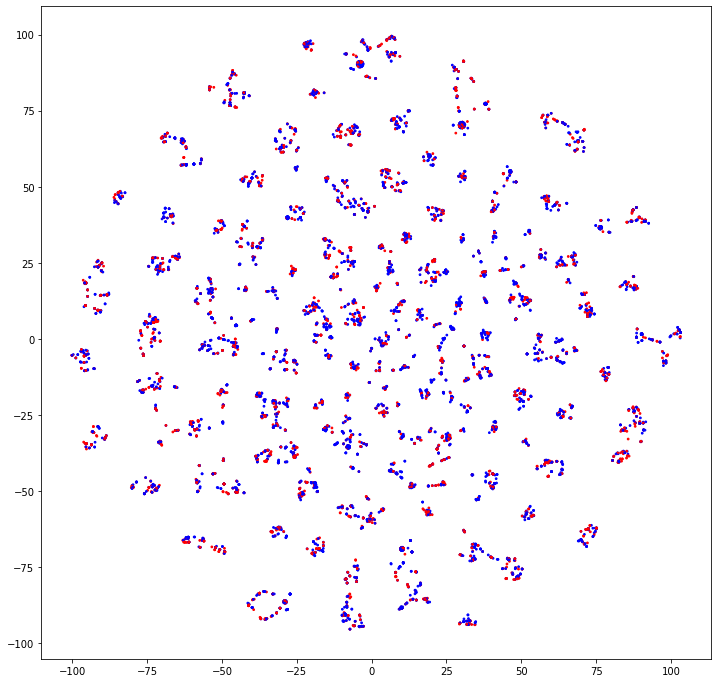

In [139]:
scatterplot(TSNE().fit_transform(X_diagnoses_lda_max), Y_all)

In [140]:
np.savetxt("data/diabetes/X_lda_max.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_lda_max])), 
           delimiter=",")

In [141]:
X_diagnoses_pca_conc = np.hstack([X_diagnoses1_pca, X_diagnoses2_pca, X_diagnoses3_pca])
print(X_diagnoses_pca_conc.shape)

(10000, 30)


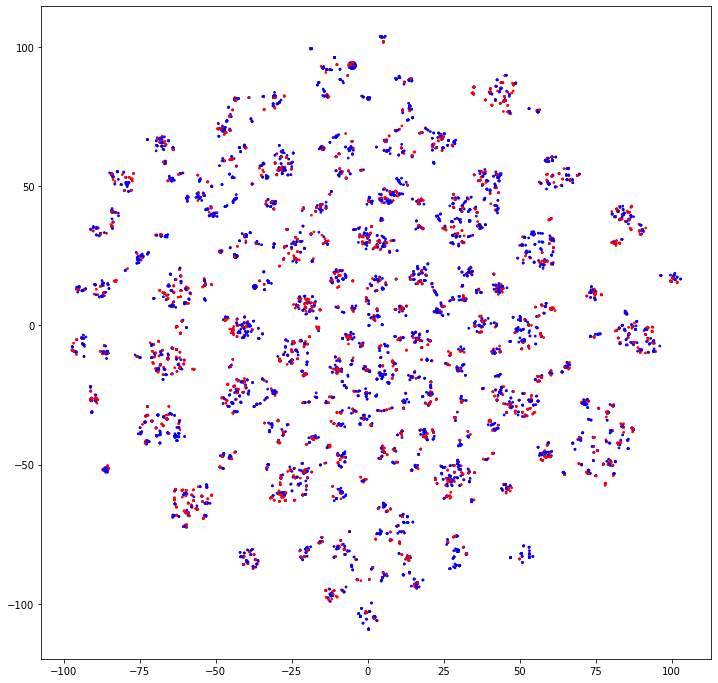

In [142]:
scatterplot(TSNE().fit_transform(X_diagnoses_pca_conc), Y_all)

In [143]:
np.savetxt("data/diabetes/X_pca_con.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_pca_conc])), 
           delimiter=",")

In [144]:
X_diagnoses_lda_conc = np.hstack([X_diagnoses1_lda, X_diagnoses2_lda, X_diagnoses3_lda])
np.savetxt("data/diabetes/X_lda_conc.csv", X_diagnoses_lda_conc, delimiter=",")
print(X_diagnoses_lda_conc.shape)

(10000, 30)


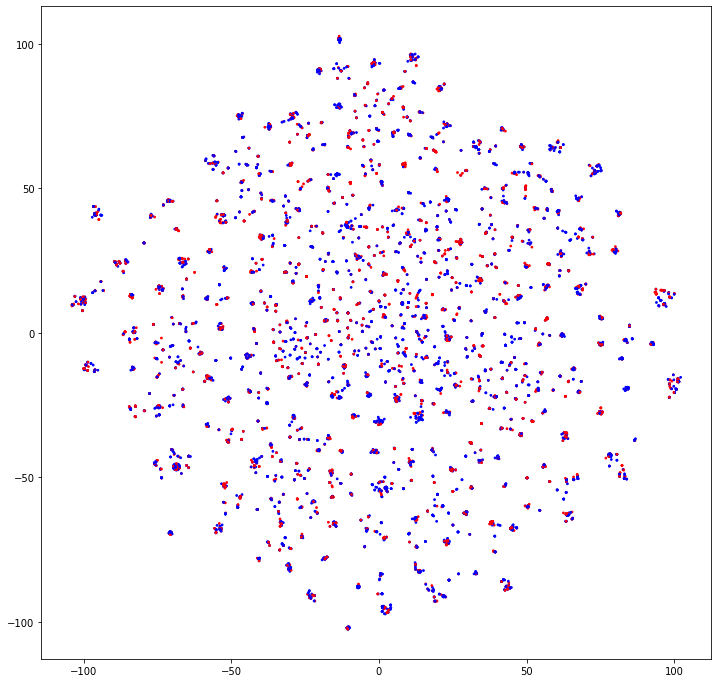

In [145]:
scatterplot(TSNE().fit_transform(X_diagnoses_lda_conc), Y_all)

In [146]:
np.savetxt("data/diabetes/X_lda_conc.csv", 
           Normalizer().fit_transform(np.hstack([X_enc, X_diagnoses_lda_conc])), 
           delimiter=",")

In [147]:
np.savetxt("data/diabetes/Y.csv", Y, delimiter=",")
np.savetxt("data/diabetes/Y_val.csv", Y_val, delimiter=",")
np.savetxt("data/diabetes/Y_test.csv", Y_test, delimiter=",")